In [ ]:
!pip install osmnx geopandas pandas scikit-learn


/var/folders/0f/xqbzpr016pd1f_xmdby2llv40000gn/T/ipykernel_4394/65875080.py:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pedestrian_routes = ox.geometries.geometries_from_place(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/osmnx/features.py:294: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/var/folders/0f/xqbzpr016pd1f_xmdby2llv40000gn/T/ipykernel_4394/65875080.py:22: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` modu

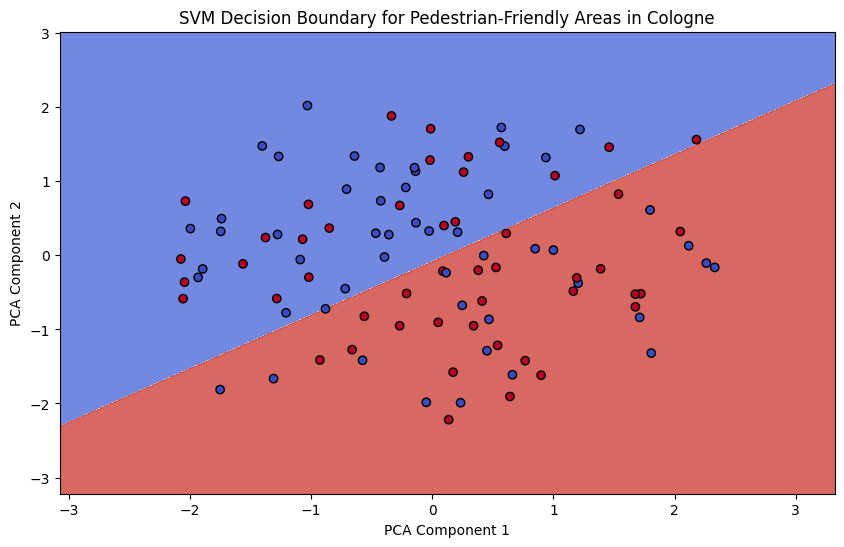

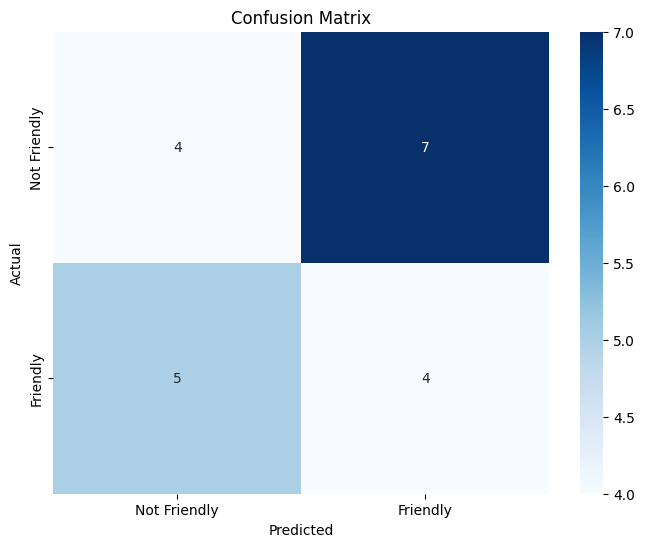

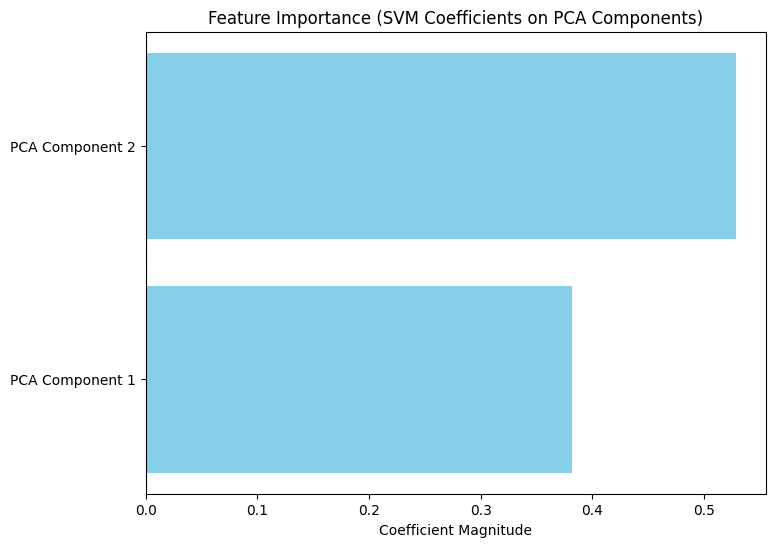

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.36      0.40        11
           1       0.36      0.44      0.40         9

    accuracy                           0.40        20
   macro avg       0.40      0.40      0.40        20
weighted avg       0.41      0.40      0.40        20



/var/folders/0f/xqbzpr016pd1f_xmdby2llv40000gn/T/ipykernel_4394/65875080.py:117: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


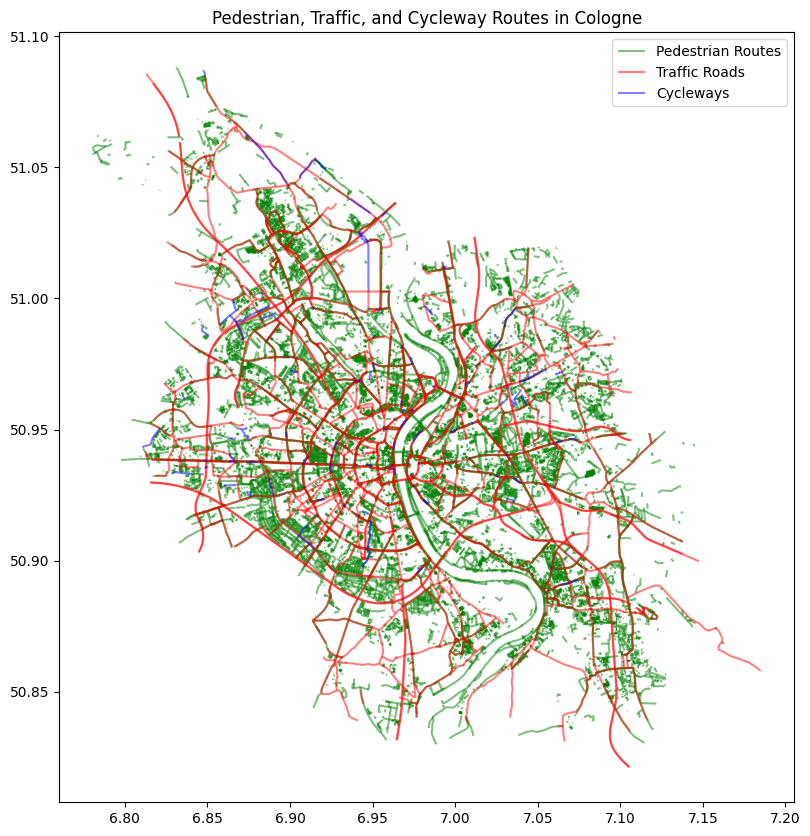

In [16]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 1: Fetch pedestrian routes and other OSM data for Cologne
place_name = "Cologne, Germany"

# Fetch all pedestrian routes
pedestrian_routes = ox.geometries.geometries_from_place(
    place_name, tags={"highway": ["footway", "pedestrian", "path"]}
)

# Fetch traffic roads
traffic_ways = ox.geometries.geometries_from_place(
    place_name, tags={"highway": ["motorway", "primary", "secondary", "tertiary"]}
)

# Fetch cycleways
cycleways = ox.geometries.geometries_from_place(
    place_name, tags={"highway": "cycleway"}
)

# Step 2: Process and summarize the data
# Calculate total lengths of pedestrian, traffic, and cycleway routes
pedestrian_length = pedestrian_routes.length.sum() if not pedestrian_routes.empty else 0
traffic_length = traffic_ways.length.sum() if not traffic_ways.empty else 0
cycleway_length = cycleways.length.sum() if not cycleways.empty else 0

# Simulate additional neighborhood data for analysis with more points
data = []
for _ in range(100):  # Generate 100 data points
    pedestrian_friendly = np.random.choice([0, 1])
    sidewalk_width = np.random.uniform(0.5, 3.5) if pedestrian_friendly else np.random.uniform(0.5, 2.0)
    pedestrian_factor = pedestrian_length * (1.0 + np.random.uniform(-0.3, 0.3))
    traffic_factor = traffic_length * (1.0 + np.random.uniform(-0.3, 0.3))
    cycleway_factor = cycleway_length * (1.0 + np.random.uniform(-0.3, 0.3))
    data.append({
        "sidewalk_width": sidewalk_width,
        "pedestrian_length": pedestrian_factor,
        "traffic_length": traffic_factor,
        "cycleway_length": cycleway_factor,
        "pedestrian_friendly": pedestrian_friendly
    })

df = pd.DataFrame(data)

# Step 3: Scale the features
X = df[["sidewalk_width", "pedestrian_length", "traffic_length", "cycleway_length"]]
y = df["pedestrian_friendly"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Train the SVM model
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model = SVC(kernel="linear", probability=True)
model.fit(X_train, y_train)

# Step 6: Visualize the decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors="k", cmap=plt.cm.coolwarm)
plt.title("SVM Decision Boundary for Pedestrian-Friendly Areas in Cologne")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Step 7: Confusion Matrix
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Friendly", "Friendly"], yticklabels=["Not Friendly", "Friendly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 8: Feature Importance
coefs = np.abs(model.coef_[0])  # Coefficients for PCA components
pca_feature_names = ["PCA Component 1", "PCA Component 2"]  # Names for PCA components

plt.figure(figsize=(8, 6))
plt.barh(pca_feature_names, coefs, color="skyblue")
plt.title("Feature Importance (SVM Coefficients on PCA Components)")
plt.xlabel("Coefficient Magnitude")
plt.show()

# Step 9: Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 10: Plot pedestrian routes on the map
fig, ax = plt.subplots(figsize=(10, 10))
pedestrian_routes.plot(ax=ax, color="green", alpha=0.5, label="Pedestrian Routes")
traffic_ways.plot(ax=ax, color="red", alpha=0.5, label="Traffic Roads")
cycleways.plot(ax=ax, color="blue", alpha=0.5, label="Cycleways")
plt.legend()
plt.title("Pedestrian, Traffic, and Cycleway Routes in Cologne")
plt.show()
